# Import lib, login HuggungFace, load dataset

## import lib

In [19]:
from transformers import pipeline 
import numpy as np
import torch
import pandas as pd 
import matplotlib.pyplot as plt
from datasets import load_metric,load_dataset
from transformers import AutoTokenizer,AutoModelForSequenceClassification
import torch.nn as nn
import torch.nn.functional as F 

from utils import *
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print("device : ",device)


device :  cpu


## loging to Hugging face

In [2]:
# login to hugging face to push model 
from huggingface_hub import login
# load token from file  .env 
import os
from dotenv import load_dotenv
load_dotenv()
token = os.getenv("HF_AUTH_TOKEN")
login(token = token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/nghiaph/.cache/huggingface/token
Login successful


## Load the dataset

In [22]:
clinc = load_dataset("clinc_oos", "plus")
intents = clinc["train"].features["intent"]
# load the dataset
clinc = load_dataset("clinc_oos", "plus")
intents = clinc["train"].features["intent"]
# load metrics
accuracy_score = load_metric("accuracy")
bert_ckpt = "phnghiapro/distilbert-base-uncased-distilled-clinc"

pipe = pipeline("text-classification", device='cpu')
# tokenizer the data
# def tokenizer_text(batch):
#     return bert_tokenizer(batch["text"],truncation=True)
# clinc_enc = clinc.map(tokenizer_text, batched=True)
# clinc_enc = clinc_enc.rename_column("intent", "labels")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


## utils

In [23]:

def benchmark_the_model(pipe,
                  dataset=clinc["test"], 
                  intents=intents, 
                  query="""I want to transfer money to my friend.""", 
                  metric=load_metric("accuracy"),
                  optim_type = "BERT baseline"):
    print(optim_type)
    benchmark = PerformanceBenchmark(pipe, dataset, intents, query, metric ,optim_type)
    return benchmark.run_benchmark()
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [24]:
# iterate over the test set and make predictions
# y_true = []
# y_pred = []
# for example in clinc["test"]:
#     y_true.append(example["intent"])
#     y_pred.append(pipe(example["text"])[0]["label"])
#     print('text : ', example["text"])
#     print(pipe(example["text"]))
#     print(pipe(example["text"])[0]["label"])
#     break

# Plot the distribution of the weights

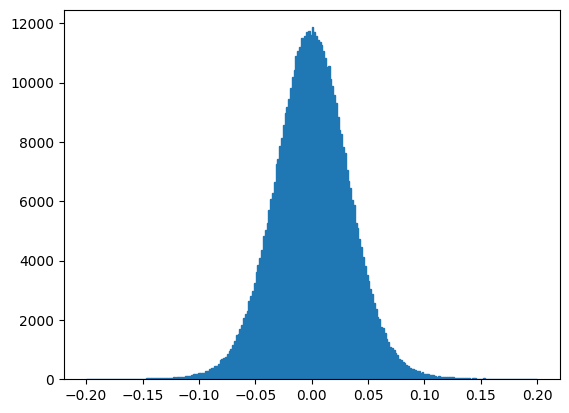

In [25]:
state_dict = pipe.model.to('cpu').state_dict()
weights = state_dict['distilbert.transformer.layer.0.attention.out_lin.weight']
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.2,0.2), edgecolor="C0")
plt.show()

In [26]:
# value distributed in small range [-0.1, 0.1]
zero_point = 0 
scale = (weights.max() - weights.min()) / 255 

In [27]:
(weights / scale + zero_point).clamp(-128,127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -3,   8],
        [  9,   3,   1,  ...,  -4,   8,   0],
        [ -9,  -6,   5,  ...,   0,   6,  -3],
        ...,
        [  5,   1,  12,  ...,   0,   5,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-12,  -1, -10,  ...,   9,   2,  -2]], dtype=torch.int8)

# Compare time and size when using quantization

In [28]:
from torch import quantize_per_tensor 
dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale=scale, zero_point=zero_point, dtype=dtype) 
quantized_weights.int_repr() 


tensor([[ -5,  -8,   0,  ...,  -6,  -3,   8],
        [  9,   3,   1,  ...,  -4,   8,   0],
        [ -9,  -6,   5,  ...,   0,   6,  -3],
        ...,
        [  5,   1,  12,  ...,   0,   5,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-12,  -1, -10,  ...,   9,   2,  -2]], dtype=torch.int8)

## compare time 

In [29]:
%%timeit
weights @ weights

1.26 ms ± 7.75 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [30]:
from torch.nn.quantized import QFunctional 
q_fn = QFunctional() 


In [31]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

96.1 µs ± 323 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [32]:
# (1.26 milliseconds) / (95.9 microseconds) =
# 13.1386861
# 13 time faster

## compare size 


In [33]:
import sys
sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())
# decrease 4 times in size
#3.999755879241598


3.999755879241598

# Quantize the model

In [34]:
from torch.quantization import quantize_dynamic 
model = (AutoModelForSequenceClassification.from_pretrained(bert_ckpt))
model_quantized = quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
# model_quantized.to(device)

# Plot all the model benchmard

### baseline model

In [35]:
bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline('text-classification', model=bert_ckpt, device='cpu') 
query = """I want to transfer money to my friend."""
pipe(query)

[{'label': 'transfer', 'score': 0.5223466753959656}]

In [36]:
from utils import PerformanceBenchmark , plot_metrics

benchmark = PerformanceBenchmark(pipe, clinc["test"], intents, query,load_metric("accuracy"),optim_type="BERT baseline")
optim_type = "BERT baseline"
# perf_metrics.update(benchmark_the_model(pipe= pipe,optim_type = optim_type))
perf_metrics = benchmark_the_model(pipe= pipe,optim_type = optim_type)

BERT baseline
Model size (MB) - 418.15
[]
Average latency ms - 0.010 +/- 0.403
Accuracy on test set - 0.867


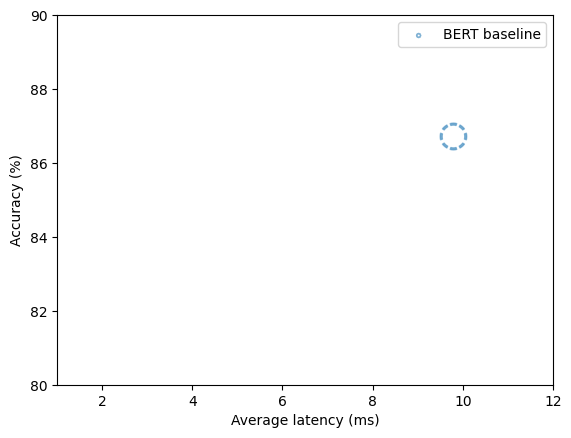

In [37]:
# plot the base model
plot_metrics(perf_metrics, optim_type)

### DistilBERT

In [38]:
finetune_ckpt = "phnghiapro/distilbert-base-uncased-fineturned-clinc"
pipe = pipeline('text-classification', model=finetune_ckpt, device=device)
optim_type = "DistilBERT"
perf_metrics.update(benchmark_the_model(pipe= pipe,optim_type = optim_type))

DistilBERT
Model size (MB) - 255.88
[]
Average latency ms - 0.005 +/- 1.176
Accuracy on test set - 0.853


### Distillation 

In [39]:
distilled_ckpt = "phnghiapro/distilbert-base-uncased-distilled-clinc"
pipe = pipeline('text-classification', model=distilled_ckpt, device=device)
optim_type = "Distillation"
perf_metrics.update(benchmark_the_model(pipe= pipe,optim_type = optim_type))

Distillation
Model size (MB) - 255.88
[]
Average latency ms - 0.007 +/- 1.005
Accuracy on test set - 0.877


### Distillation + quantization

In [40]:
optim_type = "Distillation + quantization"
model_ckpt = "phnghiapro/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
pipe = pipeline("text-classification",
                model=model_quantized,
                tokenizer=tokenizer,
                device='cpu'
                )
perf_metrics.update(benchmark_the_model(pipe= pipe,optim_type = optim_type))

Distillation + quantization
Model size (MB) - 132.39
[]
Average latency ms - 0.004 +/- 0.146
Accuracy on test set - 0.877


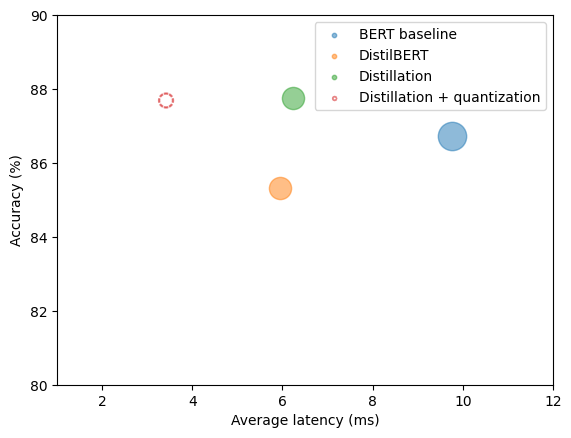

In [41]:
plot_metrics(perf_metrics, optim_type)

# Optimization by ONNX

In [44]:
import os 
from psutil import cpu_count 
os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = 'ACTIVE'


In [46]:
from transformers.convert_graph_to_onnx import convert
model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
    output=onnx_model_path, opset=12, pipeline_name="text-classification")

ONNX opset version set to: 12
Loading pipeline (model: transformersbook/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='phnghiapro/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True))
Creating folder onnx
Using framework PyTorch: 2.0.1+cu117
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


/home/nghiaph/GEC/GEC_env/lib/python3.8/site-packages/transformers/models/distilbert/modeling_distilbert.py:223: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [47]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession,
 SessionOptions)
def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    # options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session
onnx_model = create_model_for_provider(onnx_model_path)

In [48]:
from datasets import load_metric,load_dataset

clinc = load_dataset("clinc_oos", "plus")
def tokenizer_text(batch):
    return tokenizer(batch["text"],truncation=True)
clinc_enc = clinc.map(tokenizer_text, batched=True)
clinc_enc = clinc_enc.rename_column("intent", "labels")

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [49]:
inputs = clinc_enc["test"][:1] #{'input_ids': [[101, 2129, 2052, 2017, 2360, 4875, 1999, 3059, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1]]}
del inputs["labels"]
del inputs["text"]

In [55]:
logits_onnx = onnx_model.run(None, inputs)[0] #(1, 151)
print(logits_onnx.shape)
print(np.argmax(logits_onnx))
print(intents.int2str(int(np.argmax(logits_onnx))))

(1, 151)
61
translate


## Onnx Pipeline 


In [ ]:
# create ONNX pipeline 
from scipy.special import softmax 
class OnnxPipeline:
    def __init__(self, onnx_model,tokenizer):
        self.onnx_model = onnx_model
        self.tokenizer = tokenizer
    def __call__(self, query): 
        inputs = self.tokenizer(query, return_tensors="pt") # input_ids attention_mask shape (1, seq_len) vs (1, seq_len)
        inputs_onnx = {k: v.cpu().detach().numpy() for k, v in inputs.items()}
        logits = self.onnx_model.run(None, inputs_onnx)[0][0,:] # shape (n_classes,)
        probs = softmax(logits) # shape (n_classes,)
        pred_idx = np.argmax(probs).item() # shape ()
        return [{
                "label": intents.int2str(pred_idx),
                "score": probs[pred_idx]
                }]
# test the pipeline
onnx_pipe = OnnxPipeline(onnx_model,tokenizer)
query = """onnx_pipe("hey, I want to buy a macbook pro")"""
onnx_pipe(query)


[{'label': 'order', 'score': 0.19629458}]

## Overide compute size method

In [ ]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *arg,model_path, **kwargs):
        super().__init__(*arg, **kwargs)
        self.model_path = model_path
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024*1024)
        print(f"Model size MB: {size_mb:.2f} MB")
        return {"size_mb": size_mb}

# plot benchmark Onnx

In [ ]:
# change key model_size_mb to size_mv 
# Distillation + ONNX
# Model size MB: 255.98 MB
# Average latency ms - 0.013 +/- 0.330
# Accuracy on test set - 0.868
# dict = {
#     "size_mb" : 255.98,
#     "time_avg_ms" : 0.013,
#     "accuracy" : 0.868, 
#     "time_std_ms" : 0.330
# }
# perf_metrics["Distillation + ONNX"] = dict

In [ ]:
optim_type = "Distillation + ONNX"
model_path = "onnx/model.onnx"
onnx_benchmark = OnnxPerformanceBenchmark(onnx_pipe, clinc["test"], intents, query,load_metric("accuracy"),optim_type=optim_type,model_path=model_path)
perf_metrics.update(onnx_benchmark.run_benchmark())

Distillation + ONNX
Model size MB: 255.98 MB
Average latency ms - 0.004 +/- 0.083
Accuracy on test set - 0.868


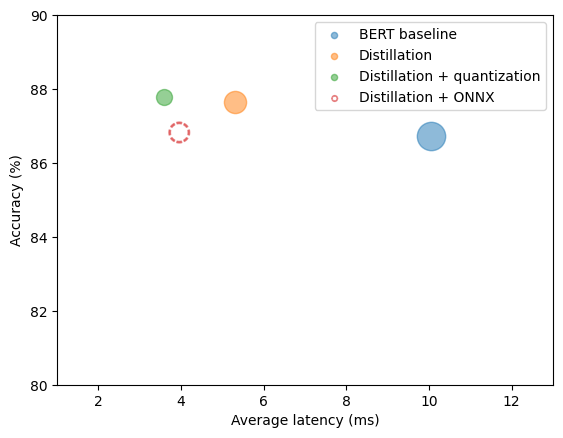

In [ ]:
plot_metrics(perf_metrics, optim_type)


# Use ORT to quantization the model


In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType
model_input = "onnx/model.onnx"
model_output = "onnx/model_quantized.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

In [ ]:
onnx_quantized_model = create_model_for_provider(model_output)
onnx_quantized_pipe = OnnxPipeline(onnx_quantized_model,tokenizer)
optim_type = "Distillation + ONNX + quantization"
print(optim_type)
pb = OnnxPerformanceBenchmark(onnx_quantized_pipe, clinc["test"], optim_type=optim_type,model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Distillation + ONNX + quantization
Model size MB: 64.33 MB
Average latency ms - 0.002 +/- 0.024
Accuracy on test set - 0.876


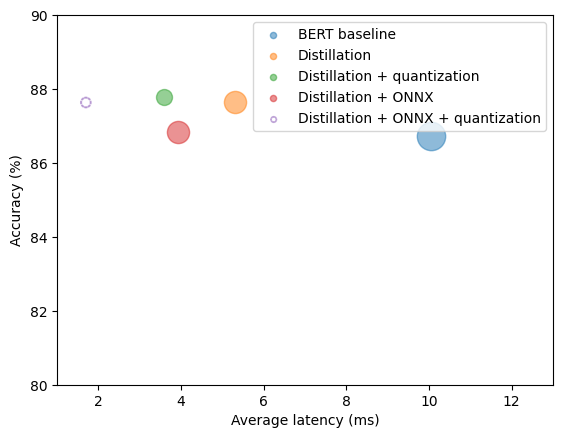

In [ ]:
plot_metrics(perf_metrics, optim_type)
